# 나이브 베이즈를 활용
### BadWord 분류기

In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report


In [2]:
train_df = pd.read_csv('../datasets/badword_train.tsv', delimiter='\t')
dev_df = pd.read_csv('../datasets/badword_dev.tsv', delimiter='\t')
badword_df = pd.concat([train_df, dev_df], ignore_index=True)

In [3]:
badword_df

,comments,contain_gender_bias,bias,hate
0,(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...,False,others,hate
1,....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...,False,none,none
2,"...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...",False,none,hate
3,"1,2화 어설펐는데 3,4화 지나서부터는 갈수록 너무 재밌던데",False,none,none
4,1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...,True,gender,hate
...,...,...,...,...
8362,지현우 범죄 저지르지 않았나요?,False,none,offensive
8363,여자인생 망칠 일 있나 ㅋㅋ,True,gender,hate
8364,근데 전라도에서 사고가 났는데 굳이 서울까지 와서 병원에 가느 이유는?,False,others,offensive
8365,"할매젖x, 뱃살x, 몸매 s라인, 유륜은 적당해야됨(너무크거나 너무 작아도 x), ...",True,gender,hate


##### 결측치 검사

In [4]:
badword_df.isna().sum()

comments               0
contain_gender_bias    0
bias                   0
hate                   0
dtype: int64

##### 중복값 검사

In [5]:
badword_df.duplicated().sum()

0

##### 레이블 인코딩

In [6]:
from sklearn.preprocessing import LabelEncoder

badword_encoder = LabelEncoder()
targets = badword_encoder.fit_transform(badword_df.hate)
badword_df['hate'] = targets

In [7]:
badword_encoder.classes_

array(['hate', 'none', 'offensive'], dtype=object)

In [8]:
class_counts = badword_df['hate'].value_counts()
print(class_counts)

hate
1    3646
2    2688
0    2033
Name: count, dtype: int64


##### 오버샘플링

In [9]:
# pip install imbalanced-learn  오버샘플링을 하기 위한 라이브러리 설치

In [10]:
# from imblearn.over_sampling import SMOTE

# # 분리할 feature와 target 정의
# X = badword_df['Message'].values.reshape(-1, 1)  # Feature
# y = badword_df['hate']  # Target

# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X, y)

# # 오버샘플링 후 각 클래스의 개수 확인
# print(pd.Series(y_resampled).value_counts())

# 오버샘플링을 시도해보려 했으나, 버젼 호환성 문제로 불가능했음. 
# 현재는 수업을 들으며 데이터 분석을 계속 해야하기때문에, 강의 버젼으로 유지하고 이후에 오버샘플링을 다시 도전해보겠음.

##### 언더샘플링

In [11]:
sample_size = 2033

# 각 클래스별로 무작위 샘플을 추출
undersampled_data = []

for category in class_counts.index:
    sample = badword_df[badword_df['hate'] == category].sample(sample_size, replace=False, random_state=42)
    undersampled_data.append(sample)

# 추출된 샘플들을 하나의 데이터프레임으로 합친다.
undersampled_df = pd.concat(undersampled_data).sample(frac=1, random_state=42).reset_index(drop=True)

print(undersampled_df['hate'].value_counts())


hate
2    2033
0    2033
1    2033
Name: count, dtype: int64


In [12]:
# 벡터화를 시연하기 위한 예제
from sklearn.feature_extraction.text import CountVectorizer

text = ["아무것도 아닌 똥꼬다리 같은 놈", 
        "애꾸눈, 병신",
        "빨갱이 계집년"]
        
count_vec = CountVectorizer()
m = count_vec.fit_transform(text)
print(m.toarray())

# 각 열번호가 뜻하는 단어
print(count_vec.vocabulary_)

[[1 0 1 0 0 1 1 0]
 [0 0 0 1 0 0 0 1]
 [0 1 0 0 1 0 0 0]]
{'아무것도': 6, '아닌': 5, '똥꼬다리': 2, '같은': 0, '애꾸눈': 7, '병신': 3, '빨갱이': 4, '계집년': 1}


In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(badword_df.comments, badword_df.hate, test_size=0.3, stratify=badword_df.hate)


In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

navie_bayes_pipeline = Pipeline([('count_vectorizer', CountVectorizer()), ('naive_bayes', MultinomialNB())])
navie_bayes_pipeline.fit(X_train, y_train)

Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('naive_bayes', MultinomialNB())])

In [15]:
prediction = navie_bayes_pipeline.predict(X_test)

prediction[prediction == 1].argsort()

print(f'예측 결과: {prediction[216]}')

print('실제 정답: {}'.format(badword_df[badword_df['comments'] == X_test.to_list()[216]].hate.to_list()[0]))

예측 결과: 2
실제 정답: 2


In [16]:
navie_bayes_pipeline.score(X_test, y_test)

0.5041816009557945

In [17]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, prediction)

0.5041816009557945

In [18]:
from sklearn.metrics import accuracy_score, precision_score , recall_score , confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt
# 타겟 데이터와 예측 객체를 전달받는다.
def get_evaluation(y_test, prediction, classifier=None, X_test=None):
#     오차 행렬
    confusion = confusion_matrix(y_test, prediction)
#     정확도
    accuracy = accuracy_score(y_test , prediction)
#     정밀도
    precision = precision_score(y_test , prediction, average='macro')
#     재현율
    recall = recall_score(y_test , prediction, average='macro')
#     F1 score
    f1 = f1_score(y_test, prediction, average='macro')

    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}'.format(accuracy , precision ,recall, f1))
    print("#" * 75)
    
    if classifier is not None and  X_test is not None:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
        titles_options = [("Confusion matrix", None), ("Normalized confusion matrix", "true")]

        for (title, normalize), ax in zip(titles_options, axes.flatten()):
            disp = ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test, ax=ax, cmap=plt.cm.Blues, normalize=normalize)
            disp.ax_.set_title(title)
        plt.show()

오차 행렬
[[189 242 179]
 [ 65 831 198]
 [136 425 246]]
정확도: 0.5042, 정밀도: 0.4781, 재현율: 0.4581, F1:0.4544
###########################################################################


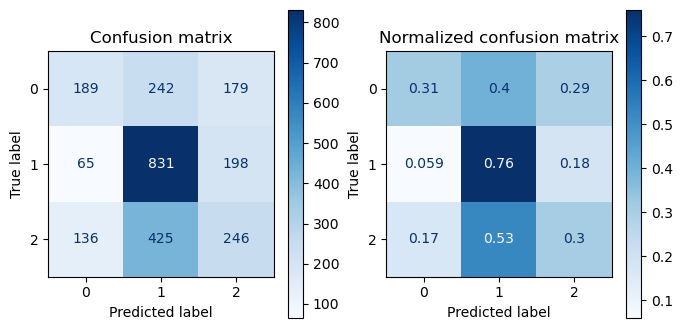

In [19]:
get_evaluation(y_test, prediction, navie_bayes_pipeline, X_test)